# Intro to Dask

See

https://docs.dask.org/en/latest/10-minutes-to-dask.html

### What is Dask?

Dask is a package that allows you to work with data sets too large to load into memory, that have to be left at least partially on disk.

Dask moves data back and forth from the disk in blocks,  which is a slow process,   so DASK runs slowly.    There are times when you really do need to access some
very large files though and other options may not be available.    If you can access a database with the content instead of using Dask with a file,   the database
approach is preferable.

DASK is pretty much a one-trick pony,  it accesses large files off of disks

## Graphviz

To run the visualization of the graphs,   we will need to install graphviz program and the graphviz python package (2 different things)

See

https://www.graphviz.org/download/

to install the graphviz package, then use

conda install -c anaconda graphviz
conda install -c conda-forge python-graphviz

to install the python driver to connect to graphviz


Note: This code seems to run fine on Colab, tested 2/6/2024

In [1]:
import numpy as np
import pandas as pd
#import graphviz

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

Creating a Dask Data frame, from an existing Pandas data frame

Note:
    The index here is a pandas date object, so this is data ordered by time
    Dask organizes dataframes by index, so dates or times are good choices of index,  
    Operations on objects with similar index values run fastest in DASK
    
    Typically,  we would be loading a dask data frame from a large file or database
    In practice,  if you can do the job with a pandas data frame alone,  don't use DASK!
    
Here the Pandas dataframe was divided up into 10 partitions (or chunks)

In [2]:
index = pd.date_range("2021-09-01", periods=2400, freq="1H")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
ddf = dd.from_pandas(df, npartitions=10)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [3]:
ddf.divisions

(Timestamp('2021-09-01 00:00:00', freq='H'),
 Timestamp('2021-09-11 00:00:00', freq='H'),
 Timestamp('2021-09-21 00:00:00', freq='H'),
 Timestamp('2021-10-01 00:00:00', freq='H'),
 Timestamp('2021-10-11 00:00:00', freq='H'),
 Timestamp('2021-10-21 00:00:00', freq='H'),
 Timestamp('2021-10-31 00:00:00', freq='H'),
 Timestamp('2021-11-10 00:00:00', freq='H'),
 Timestamp('2021-11-20 00:00:00', freq='H'),
 Timestamp('2021-11-30 00:00:00', freq='H'),
 Timestamp('2021-12-09 23:00:00', freq='H'))

In [4]:
ddf.partitions[1]

,a,b
npartitions=1,,
2021-09-11,int64,object
2021-09-21,...,...


Slicing and selecting
Acts just like a pandas data frame

In [5]:
ddf.b

Dask Series Structure:
npartitions=10
2021-09-01 00:00:00    object
2021-09-11 00:00:00       ...
                        ...  
2021-11-30 00:00:00       ...
2021-12-09 23:00:00       ...
Name: b, dtype: object
Dask Name: getitem, 2 graph layers

In [6]:
# notice that when we call for a slice,   we get no output, just the structure
ddf["2021-10-01": "2021-10-09 5:00"]

,a,b
npartitions=1,,
2021-10-01 00:00:00.000000000,int64,object
2021-10-09 05:00:59.999999999,...,...


# Dask always uses delayed execuction

Delayed execution means that Dask stores the sequence of operations you want carried out, and only executes them when you call a compute operation.

Why whould it do this?

When working with chunked data,   operations within a chunk are fast, operations that are between chunks are slow

Chunks might be only a single computer, loaded into memory one at a time, or spread over many computers (a cluster or cloud system).   Both use chunks

We would like to do as many different operations within each chunk as we can, then move to the next chunk (or communicate between chunks).

Delayed execution allows us to accumulate a series of operations

The operations are *scheduled* using a *graph*, and then executed following the pattern of operations specified in the graph

This greatly reduces time spent loading chunks, or communicating between chunks (in a cluster or cloud system)


In [7]:
# to get an action or output,  we need to call the .compute() member function
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


In [8]:
print(ddf.a.mean())



dd.Scalar<series-..., dtype=float64>


In [9]:
print(ddf.a.mean().compute())

1199.5


In [10]:
df.b.unique()

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [11]:
ddf.b.unique().compute()

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

In [12]:
# this is chained set of methods,  like pandas,  but when the value is assigned to a variable
# No calculation is done at this point
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum()

In [13]:
result

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Name: a, dtype: int64
Dask Name: series-cumsum, 6 graph layers

In [14]:
result.compute()

2021-10-01 00:00:00       720
2021-10-01 01:00:00      1441
2021-10-01 02:00:00      2163
2021-10-01 03:00:00      2886
2021-10-01 04:00:00      3610
                        ...  
2021-10-09 01:00:00    158401
2021-10-09 02:00:00    159315
2021-10-09 03:00:00    160230
2021-10-09 04:00:00    161146
2021-10-09 05:00:00    162063
Freq: H, Name: a, Length: 198, dtype: int64

# Viewing the graph used to determine how the operations will be carried out

In [15]:
# we can see what the graph stored in result is like
result.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7ff85b7fdf90>
 0. from_pandas-0cbe98d3146265102bd377c83bf54abc
 1. loc-718c9eb860303f317d596d746ca5c725
 2. getitem-77c780988ee9d431cb050895e481e5ca
 3. series-cumsum-map-1fc787e92e325aa97d1c7753cbf1a1ed
 4. series-cumsum-take-last-8d3dfa099ea49c3b2ed2dadbe6a8e6ff
 5. series-cumsum-a073ce0e199b132fa5d57060623ce23c

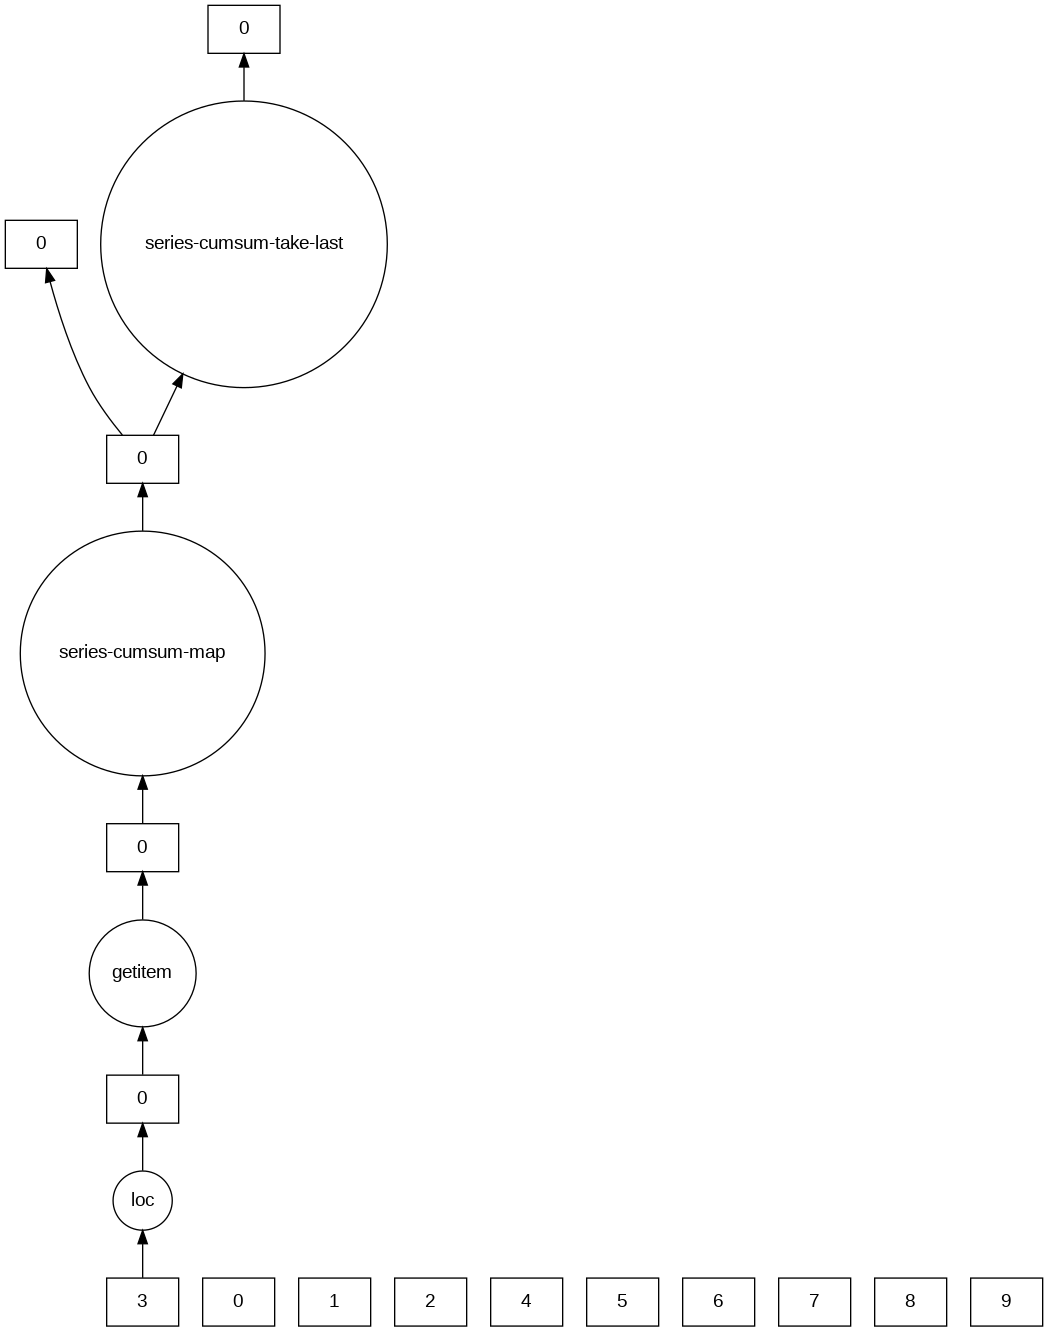

In [16]:
result.visualize()

# Delayed execution and schedule graphs are commonly used in working with large data


Dask uses sequential chunks,   moving data in and out of memory to handle a large set on one computer.   Loading chunks is the big time loss.

Spark and other distributed computational tools work in parallel on chunks on different computers,   Communicating between paralell systems is the big time loss

Tensorflow and Pytorch are frameworks for training neural networks that can use the massive (but simple) parallel processing on a GPU.  Communication and data transfer from the CPU to the GPU is the time loss.

All these systems use delayed execution,  schedulers and graphs to try to optimize how computations are carried out.

## Arrays in Dask

kind of an extension of numpy arrays,  making them easy to work with

In [17]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [18]:
# inspect the chunks
a.chunks




((100, 100), (100, 100, 100, 100, 100))

In [19]:
# access a particular block of data
a.blocks[1, 3]

dask.array<blocks, shape=(100, 100), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [20]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [21]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [22]:
a.mean().compute()

49999.5

In [23]:
np.sin(a)

dask.array<sin, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [24]:
np.sin(a).compute()

array([[ 0.        ,  0.84147098,  0.90929743, ...,  0.58781939,
         0.99834363,  0.49099533],
       [-0.46777181, -0.9964717 , -0.60902011, ..., -0.89796748,
        -0.85547315, -0.02646075],
       [ 0.82687954,  0.9199906 ,  0.16726654, ...,  0.99951642,
         0.51387502, -0.4442207 ],
       ...,
       [-0.99720859, -0.47596473,  0.48287891, ..., -0.76284376,
         0.13191447,  0.90539115],
       [ 0.84645538,  0.00929244, -0.83641393, ...,  0.37178568,
        -0.5802765 , -0.99883514],
       [-0.49906936,  0.45953849,  0.99564877, ...,  0.10563876,
         0.89383946,  0.86024828]])

In [25]:
b = a.max(axis=1)[::-1] + 10

In [26]:
b[:10].compute()

array([100009,  99509,  99009,  98509,  98009,  97509,  97009,  96509,
        96009,  95509])

In [27]:
b.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7ff85a6a4310>
 0. array-ad81ab1dac2b7083d093f897bca8f71d
 1. chunk_max-ec3182581504e4abe41164a0f843470c
 2. chunk_max-partial-85fd2851e8dd44b3424ac7f784f7eb04
 3. amax-aggregate-4aa4e4309b3814cf7fd062887e45f9a5
 4. getitem-c6ebfe19d74a2c52c68a3183e1b34cbe
 5. add-7b5a03bef2d35c1234586cf29756a695

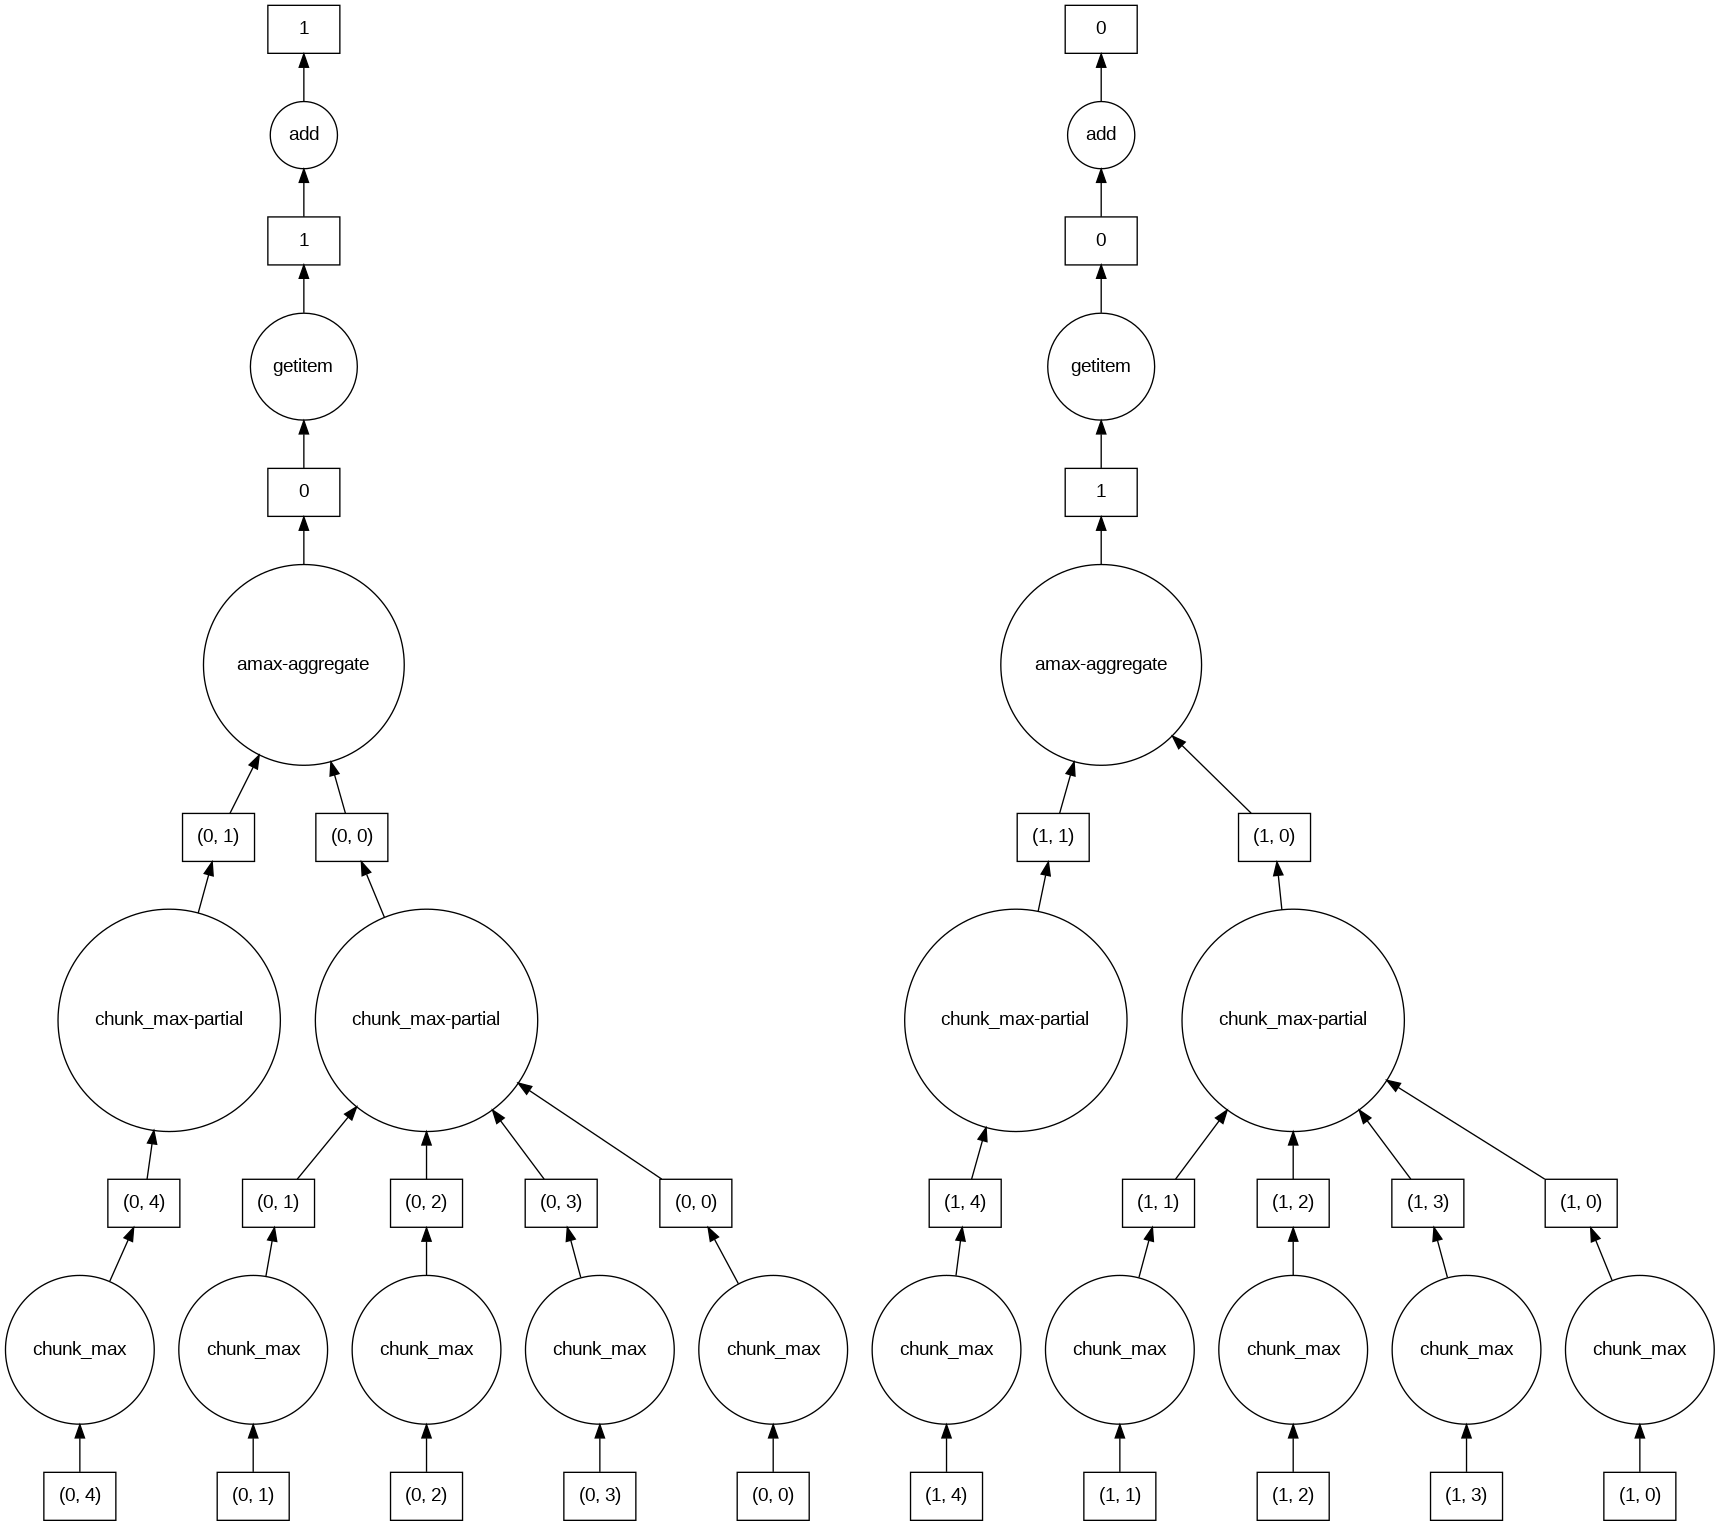

In [28]:
b.visualize()

## The Bag object

This is an unordered object allowing repeats,  it acts like a list, but with no guaranteed order

What we can do with a bag are operations such as

**map**- returns a map operator (which is iterable) from applying a given function to each item in the bag
                  map(count, x)

**filter**-filters a given sequence using a function that evaluates as tru eor false


**fold**- takes an iterable object and returns a single value

There are several instances of fold functions Python library:

**all()**, reduces the iterable based on the truthiness of all elements.

**any()**, reduces the iterable based on the truthiness of all elements.

**len()**, reduces the iterable to the number of all elements. Does not work with generators!

**max()**, reduces the iterable to the maximum of all elements.

**min(),** reduces the iterable to the minimum of all elements.

**sum()**, reduces the iterable to the sum of all elements.

and also several fold operators:

the boolean and and or operator.

the mathematical operators +, -, *, /, //, % and **.

the bitwise operators <<, >>, |, ^ and &.

the comparison operators <, <=, ==, !=, >=, >.



**groupby** -  groupby by some variable (aka a factor)  and then compute a reduction operatot
                df.groupby(['Animal']).mean()


In [29]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>

In [30]:
b.compute()

[1, 2, 3, 4, 5, 6, 2, 1]

In [31]:
# this means filter by skipping every other value in x
# this is a filter operation

b.filter(lambda x: x % 2)

dask.bag<filter-lambda, npartitions=2>

In [32]:
b.filter(lambda x: x % 2).compute()

[1, 3, 5, 1]

In [33]:
b.distinct()

dask.bag<distinct-aggregate, npartitions=1>

In [34]:

b.distinct().compute()

[1, 2, 3, 4, 5, 6]

In [35]:
c = db.zip(b, b.map(lambda x: x * 10))
c

dask.bag<zip, npartitions=2>

In [36]:
c.compute()

[(1, 10), (2, 20), (3, 30), (4, 40), (5, 50), (6, 60), (2, 20), (1, 10)]

In [37]:
c.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7ff85a6a7670>
 0. from_sequence-cca2a33ba6e12645a0c9bc0fd3fe6c88
 1. lambda-dfb9c67c3c129ed917ba12af5948f711
 2. zip-c1ab9d11e9427d2867774109e7b9508b

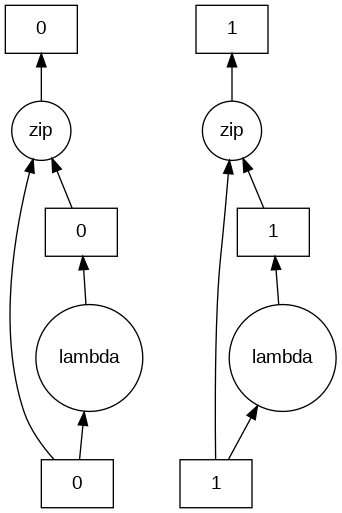

In [38]:
c.visualize()

# Low-Level Interfaces  to DASK

This interface allows you to wrap individual function calls into a lazily constructed task graph

The Lazy execution method is used by default on DASK objects such as dataframes, bags and arrays

But it is possible to embed tasks into a structure that will be converted to a graph and scheduled

In [39]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)

In [40]:
c

Delayed('add-066f0729-a630-4841-b8f1-f459519171b2')

In [41]:
c.compute()

5

###  Distributed scheduler

Allows direct control of how a computation is done.

It may be used on a local computer or on  distributed system

In [42]:
from dask.distributed import Client

client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33601
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33785'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35975'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33825', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33825
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37888
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46687', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46687
INFO:distributed.core:Sta

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33601,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:33825,Total threads: 1
Dashboard: http://127.0.0.1:42085/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:33785,


In [43]:
client.dashboard_link

'http://127.0.0.1:8787/status'

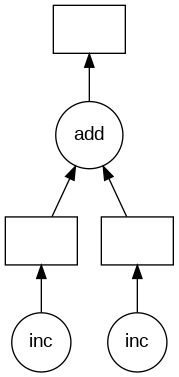

In [44]:
c.visualize()

### Futures - Immediate execution



In [45]:
from dask.distributed import Client

client = Client()

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately


/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42065 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34493
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:42065/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39281'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33507'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44109', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44109
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34766
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43171', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

In [46]:
c

<Future: pending, key: add-1394a9c7016e1fea7dc2a7c18a7510b8>

In [47]:
c.result()

5